# Notebook to prepare the dataset as input to create forcing datasets

Create one dataset as input to create the forcing dataset

Dimensions should have names: time, depth, latitude, longitude

Variables should have names: so, thetao, uo, vo, zos

Depth values should be negative and 


In [1]:
import xarray as xr
import numpy as np

In [5]:
test_data = False

In [6]:
if test_data == True:
    path = '/projects/0/einf2878/ECCO/data/resampled_test'
else:
    path = '/projects/0/einf2878/ECCO/data/resampled'
    
ssh = xr.open_dataset(f'{path}/sshdyn.nc')
theta = xr.open_dataset(f'{path}/theta.nc')
salt = xr.open_dataset(f'{path}/salt.nc')
evel = xr.open_dataset(f'{path}/evel.nc')
nvel = xr.open_dataset(f'{path}/nvel.nc')

depth = xr.open_dataset('/projects/0/einf2878/ECCO/data/nctiles/salt/SALT_1992_01.nc').Z*-1

if test_data == True:
    depth = depth.isel(k=range(3))

In [7]:
theta#.isel(k = 2, time = 0).THETA.plot()

<xarray.Dataset>
Dimensions:    (latitude: 25, longitude: 29, time: 312, k: 50)
Coordinates:
  * latitude   (latitude) float64 37.0 38.0 39.0 40.0 ... 58.0 59.0 60.0 61.0
  * longitude  (longitude) float64 -19.0 -18.0 -17.0 -16.0 ... 6.0 7.0 8.0 9.0
  * time       (time) datetime64[ns] 1992-01-16T12:00:00 ... 2017-12-16
  * k          (k) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
Data variables:
    THETA      (time, k, latitude, longitude) float32 ...

Prepare ssh by removing the global mean and selecting the ROMS area

In [25]:
# Obtain regionally averaged global mean
weights = np.cos(np.deg2rad(ssh.latitude))
ssh_weighted = ssh.weighted(weights)
ssh_global_mean = ssh_weighted.mean(['latitude', 'longitude'])

# Remove globally averaged ssh from sea-level signal
ssh['SSHDYN'] = ssh['SSHDYN'] - ssh_global_mean.SSHDYN

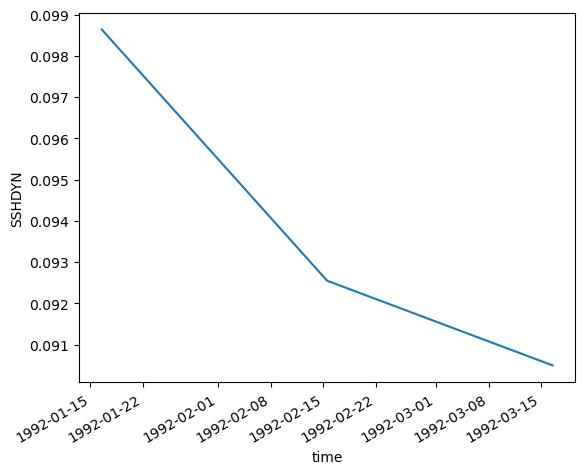

In [26]:
ssh_global_mean.SSHDYN.plot()

In [27]:
# Select ROMS area
ssh = ssh.where((ssh.longitude > -20) & (ssh.longitude < 10) & (ssh.latitude > 36) & (ssh.latitude < 62), drop = True)

In [28]:
# Create dataset

data_vars = dict(zos = (["time", "latitude", "longitude"], ssh.SSHDYN.values),
                 thetao = (["time", "depth", "latitude", "longitude"], theta.THETA.values),
                 so = (["time", "depth", "latitude", "longitude"], salt.SALT.values),
                 uo = (["time", "depth", "latitude", "longitude"], evel.EVEL.values),
                 vo = (["time", "depth", "latitude", "longitude"], nvel.NVEL.values))


coords = dict(time = (["time"], salt.time.values),
              depth = (["depth"], depth.values),
              latitude = (["latitude"], salt.latitude.values),
              longitude = (["longitude"], salt.longitude.values))


ds = xr.Dataset(data_vars = data_vars, coords = coords)

In [29]:
ds

<xarray.Dataset>
Dimensions:    (time: 3, latitude: 25, longitude: 29, depth: 3)
Coordinates:
  * time       (time) datetime64[ns] 1992-01-16T12:00:00 ... 1992-03-16T12:00:00
  * depth      (depth) float32 5.0 15.0 25.0
  * latitude   (latitude) float64 37.0 38.0 39.0 40.0 ... 58.0 59.0 60.0 61.0
  * longitude  (longitude) float64 -19.0 -18.0 -17.0 -16.0 ... 6.0 7.0 8.0 9.0
Data variables:
    zos        (time, latitude, longitude) float64 -0.3078 -0.3012 ... nan nan
    thetao     (time, depth, latitude, longitude) float32 17.03 16.92 ... nan
    so         (time, depth, latitude, longitude) float32 36.34 36.34 ... nan
    uo         (time, depth, latitude, longitude) float32 0.04271 ... nan
    vo         (time, depth, latitude, longitude) float32 0.04223 ... nan

In [30]:
# Save dataset
if test_data == True:
    ds.to_netcdf('/projects/0/einf2878/ECCO/data/forcing_input/ecco_test.nc')
else:
    ds.to_netcdf('/projects/0/einf2878/ECCO/data/forcing_input/ecco.nc')

## Prepare dataset with interp_monthly

In [49]:
import xarray as xr
import numpy as np

In [50]:
path = '/projects/0/einf2878/ROMS/data/ECCO/interp_monthly'

ssh = xr.open_mfdataset(f'{path}/SSHDYN/*.nc')
theta = xr.open_mfdataset(f'{path}/THETA/*.nc')
salt = xr.open_mfdataset(f'{path}/SALT/*.nc')
evel = xr.open_mfdataset(f'{path}/EVEL/*.nc')
nvel = xr.open_mfdataset(f'{path}/NVEL/*.nc')

In [51]:
ssh_in = ssh
theta_in = theta
salt_in = salt
evel_in = evel
nvel_in = nvel

### Remove weighted global mean from the sea-level data

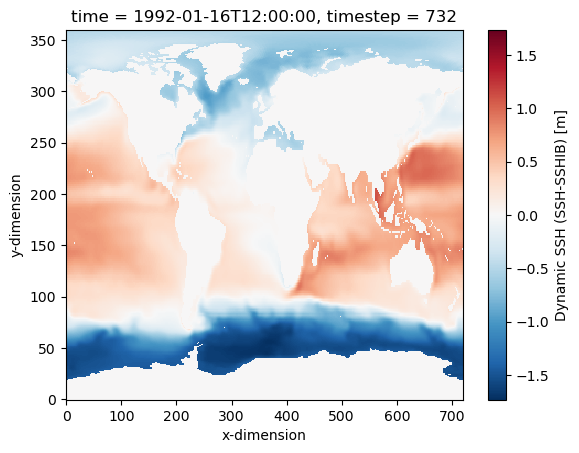

In [52]:
ssh.SSHDYN.isel(time=0).plot()

In [53]:
# Change values 
ssh['i'] = ssh.longitude
ssh['j'] = ssh.latitude

# Select DataArray
ssh_sshdyn = ssh.SSHDYN

# Drop variables and change names
ssh_sshdyn = ssh_sshdyn.drop(['latitude', 'longitude', 'timestep'])
ssh_sshdyn = ssh_sshdyn.rename({'i': 'longitude', 'j': 'latitude'})

# Obtain regionally averaged global mean
weights = np.cos(np.deg2rad(ssh_sshdyn.latitude))
ssh_weighted = ssh_sshdyn.weighted(weights)
ssh_global_mean = ssh_weighted.mean(['latitude', 'longitude'])

# Remove globally averaged ssh from sea-level signal
ssh = ssh_sshdyn - ssh_global_mean

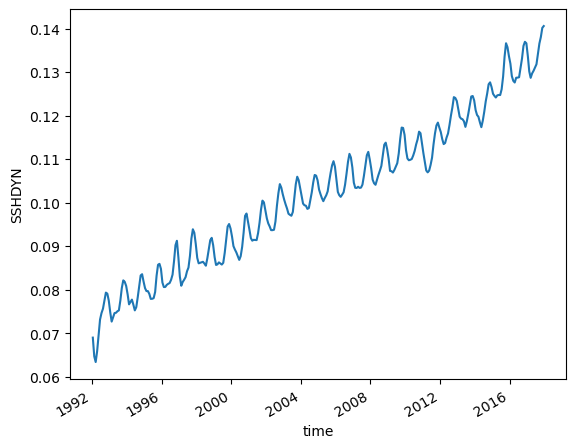

In [54]:
ssh_global_mean.plot()

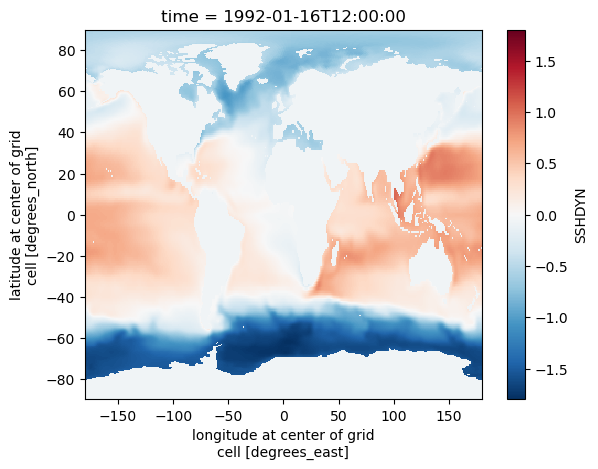

In [55]:
ssh.isel(time=0).plot()

In [56]:
# Select ROMS area
ssh = ssh.where((ssh.longitude > -20) & (ssh.longitude < 10) & (ssh.latitude > 36) & (ssh.latitude < 62), drop = True)

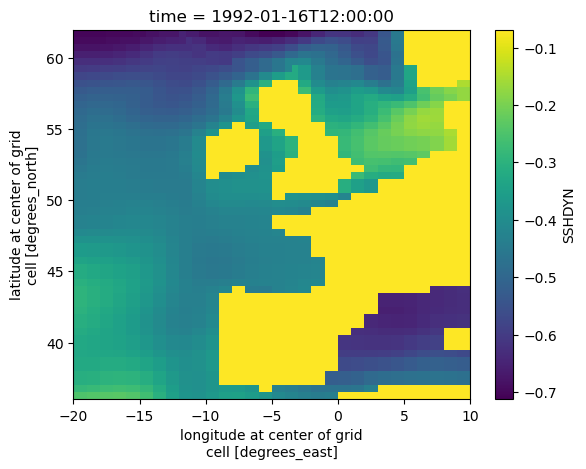

In [57]:
ssh.isel(time=0).plot()

In [58]:
# Make land values NaN
ssh = ssh.where(ssh < -0.06899647, np.nan)

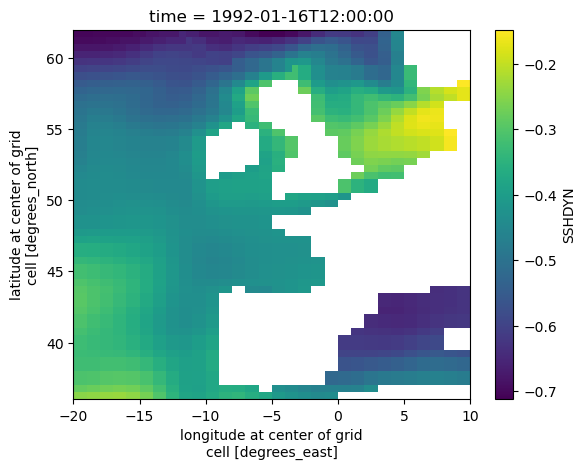

In [59]:
ssh.isel(time=0).plot()

### Prepare temperature, salinity and currents

In [61]:
data_list = [theta, salt, nvel, evel]
var_list = ['THETA', 'SALT', 'NVEL', 'EVEL']
result_list = []

for i, dataset in enumerate(data_list):
    
    # Change values 
    dataset['i'] = dataset.longitude
    dataset['j'] = dataset.latitude
    dataset['k'] = dataset.Z*-1
    
    # Select DataArray
    dataset = dataset[var_list[i]]
    
    # Drop variables and change names
    dataset = dataset.drop(['latitude', 'longitude', 'timestep', 'Z'])
    dataset = dataset.rename({'i': 'longitude', 'j': 'latitude', 'k': 'depth'})
    
    # Select ROMS area
    dataset = dataset.where((dataset.longitude > -20) & (dataset.longitude < 10) & (dataset.latitude > 36) & (dataset.latitude < 62), drop = True)
    
    # Make land values NaN
    dataset = dataset.where(dataset != 0., np.nan)
    
    # Save new dataset
    result_list.append(dataset)

/home/ikeizer/.conda/envs/py39/lib/python3.10/site-packages/xarray/core/indexing.py:1233: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
/home/ikeizer/.conda/envs/py39/lib/python3.10/site-packages/xarray/core/indexing.py:1233: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  val

In [62]:
result_list.append(ssh)

ds = xr.merge(result_list)

In [63]:
ds = ds.rename({'THETA': 'thetao', 'SALT': 'so', 'NVEL': 'vo', 'EVEL': 'uo', 'SSHDYN': 'zos'})

### Check results

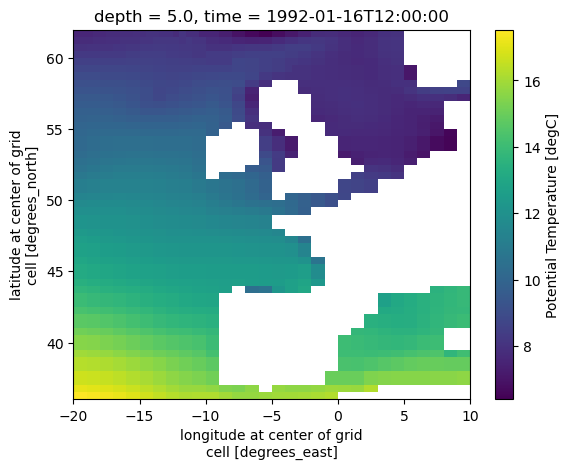

In [68]:
ds.thetao.isel(time = 0, depth = 0).plot()

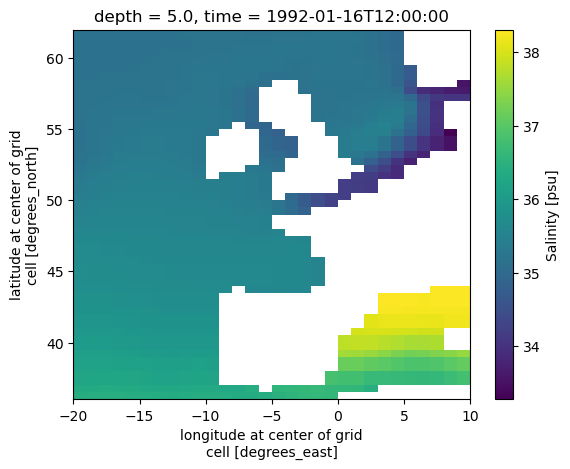

In [69]:
ds.so.isel(time = 0, depth = 0).plot()

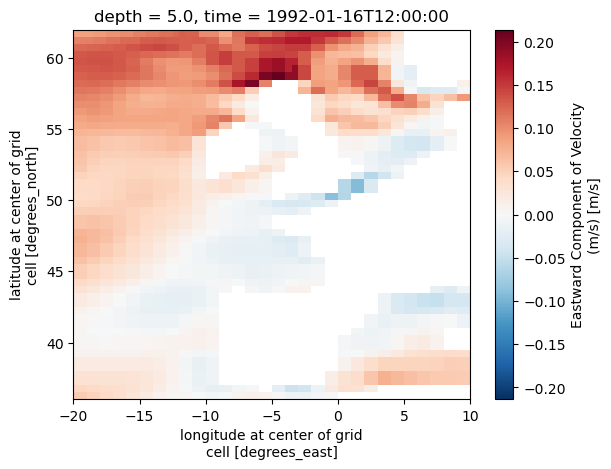

In [70]:
ds.uo.isel(time = 0, depth = 0).plot()

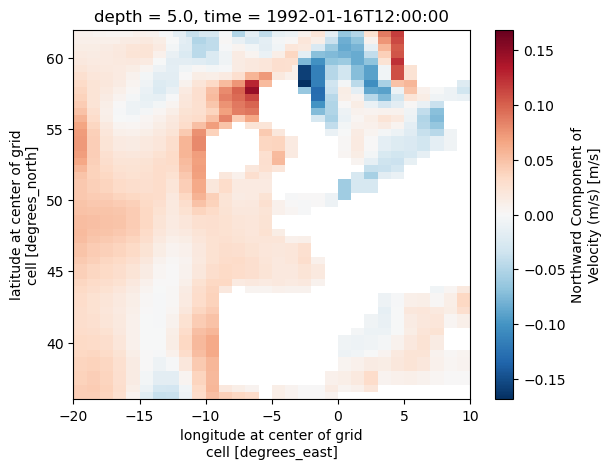

In [71]:
ds.vo.isel(time = 0, depth = 0).plot()

### Save data sets

In [65]:
# Save dataset
ds.to_netcdf('/projects/0/einf2878/ROMS/data/ECCO/forcing_input/forcing_input.nc')

In [66]:
# Create test dataset
ds_test = ds.isel(time=range(3))
ds_test.to_netcdf('/projects/0/einf2878/ROMS/data/ECCO/forcing_input/forcing_input_test.nc')

In [34]:
import xarray as xr
import numpy as np

In [3]:
path = '/projects/0/einf2878/ROMS/data/ECCO/interp_monthly'

ssh = xr.open_mfdataset(f'{path}/SSHDYN/*.nc')

In [18]:
ssh.attrs

{'product_time_coverage_start': '1992-01-01T12:00:00',
 'author': 'Ou Wang and Ian Fenty',
 'Insitution': 'JPL',
 'product_version': 'ECCO Version 4 Release 4',
 'time_units': 'days since 1992-01-01 00:00:00',
 'Conventions': 'CF-1.6',
 'Project': 'Estimating the Circulation and Climate of the Ocean',
 'cdm_data_type': 'Grid',
 'geospatial_lon_units': 'degrees_east',
 'Metadata_Conventions': 'CF-1.6, Unidata Dataset Discovery v1.0, GDS v2.0',
 'no_data': 'NaNf',
 'geospatial_lat_units': 'degrees_north',
 'product_time_coverage_end': '2017-12-31T12:00:00',
 'geospatial_vertical_min': 0,
 'nz': 1,
 'geospatial_vertical_units': 'meter',
 'geospatial_vertical_max': 0,
 'date_created': 'Wed Oct 23 23:06:44 2019',
 'time_coverage_start': '1992-01-01T00:00:00',
 'time_coverage_end': '1992-02-01T00:00:00'}

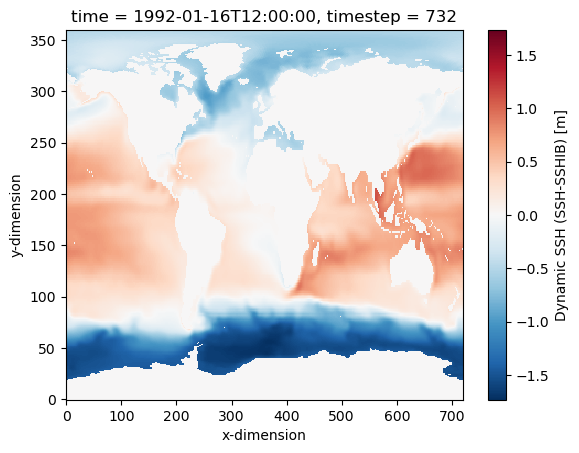

In [7]:
ssh.SSHDYN.isel(time=0).plot()

In [17]:
ssh.isel(time=0, j=270, i=380).SSHDYN.values

array(0.)

In [9]:
forcing_input = xr.open_dataset('/projects/0/einf2878/ROMS/data/ECCO/forcing_input/forcing_input.nc')

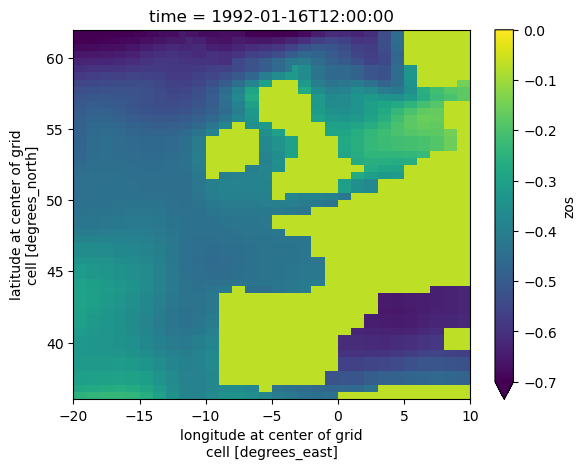

In [39]:
forcing_input.zos.isel(time=0).plot(vmin = -0.7, vmax = 0)

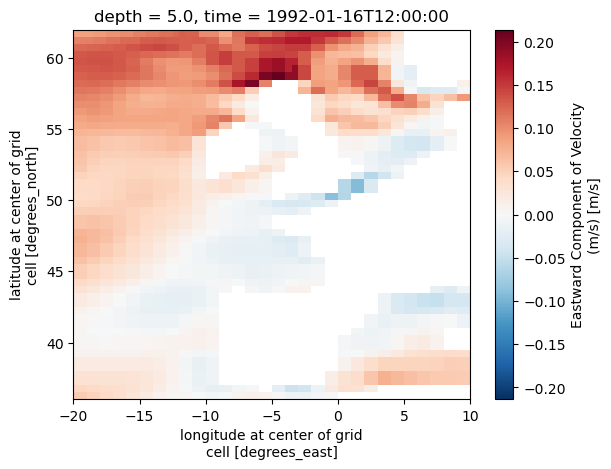

In [48]:
forcing_input.uo.where(forcing_input.uo != 0., np.nan).isel(depth = 0, time=0).plot()

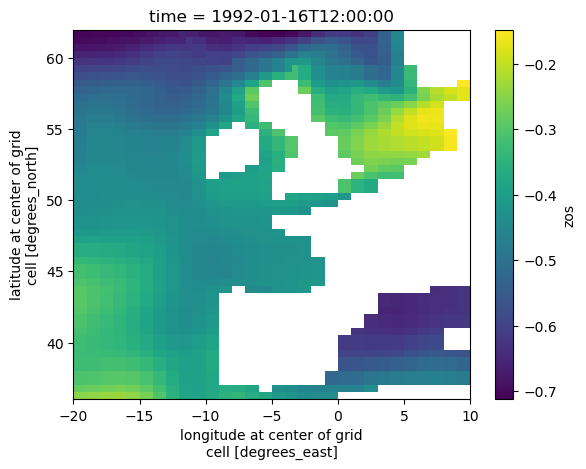

In [45]:
forcing_input.zos.isel(time=0).where(forcing_input.zos.isel(time=0) < -0.06899647, np.nan).plot()

In [37]:
forcing_input.zos

<xarray.DataArray 'zos' (time: 312, latitude: 52, longitude: 60)>
array([[[-0.249048, -0.249048, ..., -0.068996, -0.068996],
        [-0.283699, -0.283699, ..., -0.068996, -0.068996],
        ...,
        [-0.698075, -0.69765 , ..., -0.068996, -0.068996],
        [-0.704772, -0.703984, ..., -0.068996, -0.068996]],

       [[-0.242163, -0.242163, ..., -0.06469 , -0.06469 ],
        [-0.278817, -0.278817, ..., -0.06469 , -0.06469 ],
        ...,
        [-0.732022, -0.729389, ..., -0.06469 , -0.06469 ],
        [-0.74009 , -0.738425, ..., -0.06469 , -0.06469 ]],

       ...,

       [[-0.120618, -0.120618, ..., -0.140198, -0.140198],
        [-0.131463, -0.131463, ..., -0.140198, -0.140198],
        ...,
        [-0.65054 , -0.647967, ..., -0.140198, -0.140198],
        [-0.647398, -0.643427, ..., -0.140198, -0.140198]],

       [[-0.140061, -0.140061, ..., -0.140616, -0.140616],
        [-0.149659, -0.149659, ..., -0.140616, -0.140616],
        ...,
        [-0.676034, -0.674567, ..., -0.140616, -0.140616],
        [-0.67433 , -0.672356, ..., -0.140616, -0.140616]]])
Coordinates:
  * longitude  (longitude) float64 -19.75 -19.25 -18.75 ... 8.75 9.25 9.75
  * latitude   (latitude) float64 36.25 36.75 37.25 37.75 ... 60.75 61.25 61.75
  * time       (time) datetime64[ns] 1992-01-16T12:00:00 ... 2017-12-16

In [ ]:
result['u'] = result.u.where(grdROMS.mask_u == 1, grdROMS.fillval.data)

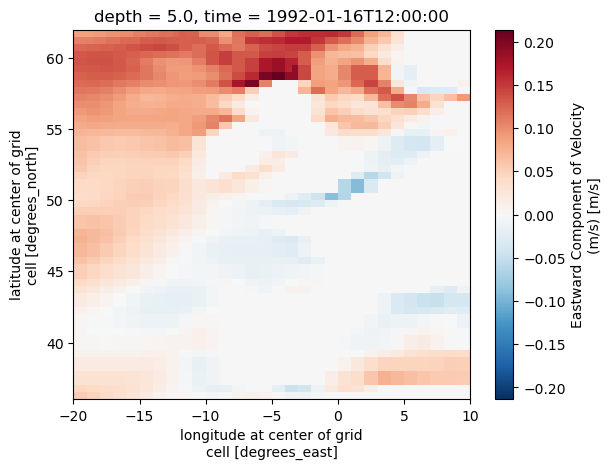

In [28]:
forcing_input.uo.

In [32]:
forcing_input.zos.isel(time=0).sel(longitude=5, latitude=48, method='Nearest').values

/home/ikeizer/.conda/envs/py39/lib/python3.10/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/ikeizer/.conda/envs/py39/lib/python3.10/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(


array(-0.06899647)

In [12]:
forcing_input.zos.isel(time=0).max()

<xarray.DataArray 'zos' ()>
array(-0.06899647)
Coordinates:
    time     datetime64[ns] 1992-01-16T12:00:00

In [21]:
ssh.attrs

{'product_time_coverage_start': '1992-01-01T12:00:00',
 'author': 'Ou Wang and Ian Fenty',
 'Insitution': 'JPL',
 'product_version': 'ECCO Version 4 Release 4',
 'time_units': 'days since 1992-01-01 00:00:00',
 'Conventions': 'CF-1.6',
 'Project': 'Estimating the Circulation and Climate of the Ocean',
 'cdm_data_type': 'Grid',
 'geospatial_lon_units': 'degrees_east',
 'Metadata_Conventions': 'CF-1.6, Unidata Dataset Discovery v1.0, GDS v2.0',
 'no_data': 'NaNf',
 'geospatial_lat_units': 'degrees_north',
 'product_time_coverage_end': '2017-12-31T12:00:00',
 'geospatial_vertical_min': 0,
 'nz': 1,
 'geospatial_vertical_units': 'meter',
 'geospatial_vertical_max': 0,
 'date_created': 'Wed Oct 23 23:06:44 2019',
 'time_coverage_start': '1992-01-01T00:00:00',
 'time_coverage_end': '1992-02-01T00:00:00'}

In [9]:
532742400/150

3551616.0